In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from datetime import datetime

# Load actors with score

In [7]:
actors = pd.read_csv('fomc_scorecard.csv', sep=";", index_col=3, header=0)
actors = actors[actors['Score'] != 0]
actors.drop('Shifted score', inplace=True, axis=1)

# Load articles

In [8]:
from pymongo import MongoClient

In [9]:
client = MongoClient('localhost', 27017)
fomc_collection = client.python_import.fomc_articles

In [10]:
fomc_articles = pd.DataFrame(list(fomc_collection.find()))
fomc_articles.set_index('_id', inplace=True)

# Merge articles and actors score

In [11]:
fomc_articles_scored = fomc_articles.merge(actors, left_on='ParticipantName', right_index=True)
fomc_articles_scored.head(2)

,ParticipantJobTitle,ParticipantLocation,ParticipantName,ParticipantTitleLastName,ParticipantUrl,RemarkDate,RemarkDescription,RemarkType,content,date,url,Name,Score
_id,,,,,,,,,,,,,
58cab2973740f50f2c6fdccb,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Dec. 03, 2013",Lacker Testifies on Bankruptcy and Financial I...,Testimony,Good morning. I am honored to speak to the Sub...,2013-12-03 00:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2
58cab29e3740f50f2c6fdcce,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Apr. 18, 2013 (8:06 AM ET)",Fed's Lacker Would End QE Now,Video Interview,Fed's Lacker Would End QE Now\n\t\t\t\t\n In a...,2013-04-18 08:06:00,http://video.cnbc.com/gallery/?video=3000162414,Jeffrey M. Lacker,2


# Number of articles in each score class

In [12]:
fomc_articles_scored.groupby('Score')['url'].count()

Score
-2    148
-1    168
 1    150
 2     72
Name: url, dtype: int64

# Create train data and test data

In [14]:
train_data = fomc_articles_scored[fomc_articles_scored['date'] < datetime(2016, 6, 1)]
test_data = fomc_articles_scored[fomc_articles_scored['date'] >= datetime(2016, 6, 1)]

In [15]:
X_train = train_data['content']
y_train = train_data['Score']
X_test = test_data['content']
y_test = test_data['Score']

# Tf-Idf and Multinomial Naive-Bayes model

### GridSearch on pipeline - it takes 20+ minutes on my machine!!!!!!!
###### http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

In [12]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('bayes_model', MultinomialNB())
])
#pipeline.fit(X_train, y_train)

params = dict(bow__ngram_range=[(1,1), (1,2), (1,3)],
              bow__max_df=np.arange(0.1,0.4,0.1),
              bow__min_df=[2,3,4],
              bayes_model__alpha=[0.1, 0.2, 0.3, 0.4, 0.5, 1])
grid_search = GridSearchCV(pipeline, 
                           param_grid=params, 
                           verbose=3, 
                           scoring='precision_macro', 
                           n_jobs=8,
                           refit=True,
                           cv=5)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed: 14.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...=False, use_idf=True)), ('bayes_model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'bow__ngram_range': [(1, 1), (1, 2), (1, 3)], 'bow__max_df': array([ 0.1,  0.2,  0.3,  0.4]), 'bow__min_df': [2, 3, 4], 'bayes_model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision_macro', verbose=3)

In [13]:
grid_search.best_params_

{'bayes_model__alpha': 0.2,
 'bow__max_df': 0.20000000000000001,
 'bow__min_df': 3,
 'bow__ngram_range': (1, 2)}

In [14]:
grid_search.best_score_

0.85989859013505876

### Fitting the model

In [16]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english', max_df=0.2, min_df=3, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('bayes_model', MultinomialNB(alpha=0.1))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=3,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        s...=False, use_idf=True)), ('bayes_model', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [17]:
y_predicted = pipeline.predict(X_test)

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [18]:
cm = confusion_matrix(y_test, y_predicted)

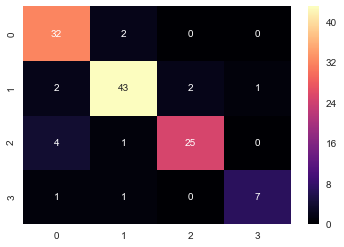

In [19]:
sns.heatmap(cm, cmap='magma', annot=True)

In [20]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

         -2       0.82      0.94      0.88        34
         -1       0.91      0.90      0.91        48
          1       0.93      0.83      0.88        30
          2       0.88      0.78      0.82         9

avg / total       0.89      0.88      0.88       121



# Examine false classifications

In [21]:
test_data['Classified Score'] = y_predicted

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
false_classifications = test_data[y_test != y_predicted]

In [23]:
false_classifications.drop(false_classifications.columns[[0,1,3,4,5,6,7]], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
false_classifications

,ParticipantName,content,date,url,Name,Score,Classified Score
_id,,,,,,,
58cab4283740f50f2c6fe00d,Jeffrey Lacker,Download MP3\n Thank you for the invitation to...,2016-09-02 01:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,-2
58cab45e3740f50f2c6fe07e,Jeffrey Lacker,I’d like to thank the organizers for the oppor...,2017-03-03 10:15:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,-1
58cab42d3740f50f2c6fe01b,Janet Yellen,"Chairman Hensarling, Ranking Member Waters, an...",2016-09-28 10:00:00,https://www.federalreserve.gov/newsevents/test...,"Janet L. Yellen, Chair",-1,-2
58cab3fd3740f50f2c6fdf97,James Bullard,A New Characterization of the U.S. Macroeconom...,2016-06-30 03:15:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-2
58cab43d3740f50f2c6fe057,James Bullard,Strong Banks. Strong Communities. Strong Econo...,2016-09-28 10:15:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-1
58cab4413740f50f2c6fe059,James Bullard,Safe Real Interest Rates and Fed Policy\n Low ...,2016-11-10 09:15:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-2
58cab45f3740f50f2c6fe083,James Bullard,Five Macroeconomic Questions for 2017\n \n\n B...,2017-01-12 01:15:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-2
58cab4633740f50f2c6fe086,James Bullard,The 2017 Outlook for U.S. Monetary Policy\n \n...,2017-02-09 09:05:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-2
58cab4363740f50f2c6fe048,Lael Brainard,"The ""Gig"" Economy: Implications of the Growth ...",2016-11-17 12:30:00,https://www.federalreserve.gov/newsevents/spee...,Lael Brainard,-2,-1


In [ ]:
for index, row in false_classifications.iterrows():
    file_name = '{}__{}__{}__{}'.format(row['ParticipantName'], row['date'].date(), row['Score'], row['Classified Score'])
    full_name = './multinomial_false_classifications/' + file_name + '.txt'
    with open(file=full_name, mode='x', encoding='utf-8') as f:
        f.write(row['content'])